# Pneumonia Detection from Chest X-Rays

Binary classification: NORMAL vs PNEUMONIA

This notebook uses the same architecture and approach as the brain tumor classifier for consistency:
- EfficientNet-V2-S with transfer learning
- PyTorch
- Mixed precision training
- Grad-CAM visualization

Dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

## 1. Setup and GPU Check

In [1]:
import torch

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"GPU Available: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
else:
    device = torch.device('cpu')
    print("No GPU found. Go to Runtime > Change runtime type > GPU")

print(f"\nUsing device: {device}")

GPU Available: Tesla T4
Memory: 15.8 GB

Using device: cuda


## 2. Kaggle Setup

In [2]:
!pip install -q kaggle

In [3]:
from google.colab import files
import os

os.makedirs('/root/.kaggle', exist_ok=True)

print("Upload your kaggle.json file:")
uploaded = files.upload()

!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
print("\nKaggle credentials configured")

Upload your kaggle.json file:


Saving kaggle.json to kaggle.json

Kaggle credentials configured


In [4]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia --unzip -p ./data

print("\nDataset downloaded")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:25<00:00, 65.7MB/s]
100% 2.29G/2.29G [00:25<00:00, 95.8MB/s]

Dataset downloaded


In [5]:
# Verify dataset structure
import os

DATA_ROOT = './data/chest_xray'

for split in ['train', 'val', 'test']:
    split_path = os.path.join(DATA_ROOT, split)
    if os.path.exists(split_path):
        print(f"{split}/")
        for class_name in sorted(os.listdir(split_path)):
            class_path = os.path.join(split_path, class_name)
            if os.path.isdir(class_path):
                count = len(os.listdir(class_path))
                print(f"  {class_name}: {count} images")

train/
  NORMAL: 1341 images
  PNEUMONIA: 3875 images
val/
  NORMAL: 8 images
  PNEUMONIA: 8 images
test/
  NORMAL: 234 images
  PNEUMONIA: 390 images


In [6]:
# Set paths
TRAIN_PATH = './data/chest_xray/train'
VAL_PATH = './data/chest_xray/val'
TEST_PATH = './data/chest_xray/test'

# Note: The original val set is very small (16 images)
# We'll combine train data and create our own split later

## 3. Import Libraries

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, ConcatDataset
from torchvision import datasets, transforms, models
from torch.amp import GradScaler, autocast
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import json
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.9.0+cu126


## 4. Data Preprocessing and Augmentation

In [8]:
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

print("Transforms defined")

Transforms defined


In [9]:
# Load datasets
# The original validation set is too small (8 per class), so we'll create our own split

train_dataset_full = datasets.ImageFolder(root=TRAIN_PATH, transform=train_transform)
train_dataset_for_val = datasets.ImageFolder(root=TRAIN_PATH, transform=val_transform)
test_dataset = datasets.ImageFolder(root=TEST_PATH, transform=val_transform)

# Create train/val split from training data (85/15)
train_size = int(0.85 * len(train_dataset_full))
val_size = len(train_dataset_full) - train_size

# Generate indices
indices = torch.randperm(len(train_dataset_full), generator=torch.Generator().manual_seed(42))
train_indices = indices[:train_size]
val_indices = indices[train_size:]

train_dataset = torch.utils.data.Subset(train_dataset_full, train_indices)
val_dataset = torch.utils.data.Subset(train_dataset_for_val, val_indices)

# Class names
class_names = train_dataset_full.classes
num_classes = len(class_names)

print(f"\nDataset Split:")
print(f"  Training:   {len(train_dataset)} images")
print(f"  Validation: {len(val_dataset)} images")
print(f"  Testing:    {len(test_dataset)} images")
print(f"\nClasses ({num_classes}): {class_names}")


Dataset Split:
  Training:   4433 images
  Validation: 783 images
  Testing:    624 images

Classes (2): ['NORMAL', 'PNEUMONIA']


In [10]:
# Check class distribution
from collections import Counter

train_labels = [train_dataset_full.targets[i] for i in train_indices.tolist()]
label_counts = Counter(train_labels)

print("Training set class distribution:")
for idx, count in sorted(label_counts.items()):
    print(f"  {class_names[idx]}: {count} images")

# Note: Dataset is imbalanced (more PNEUMONIA than NORMAL)
# We'll use class weights to handle this

Training set class distribution:
  NORMAL: 1115 images
  PNEUMONIA: 3318 images


In [11]:
# Create DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"DataLoaders created (batch_size={BATCH_SIZE})")

DataLoaders created (batch_size=32)


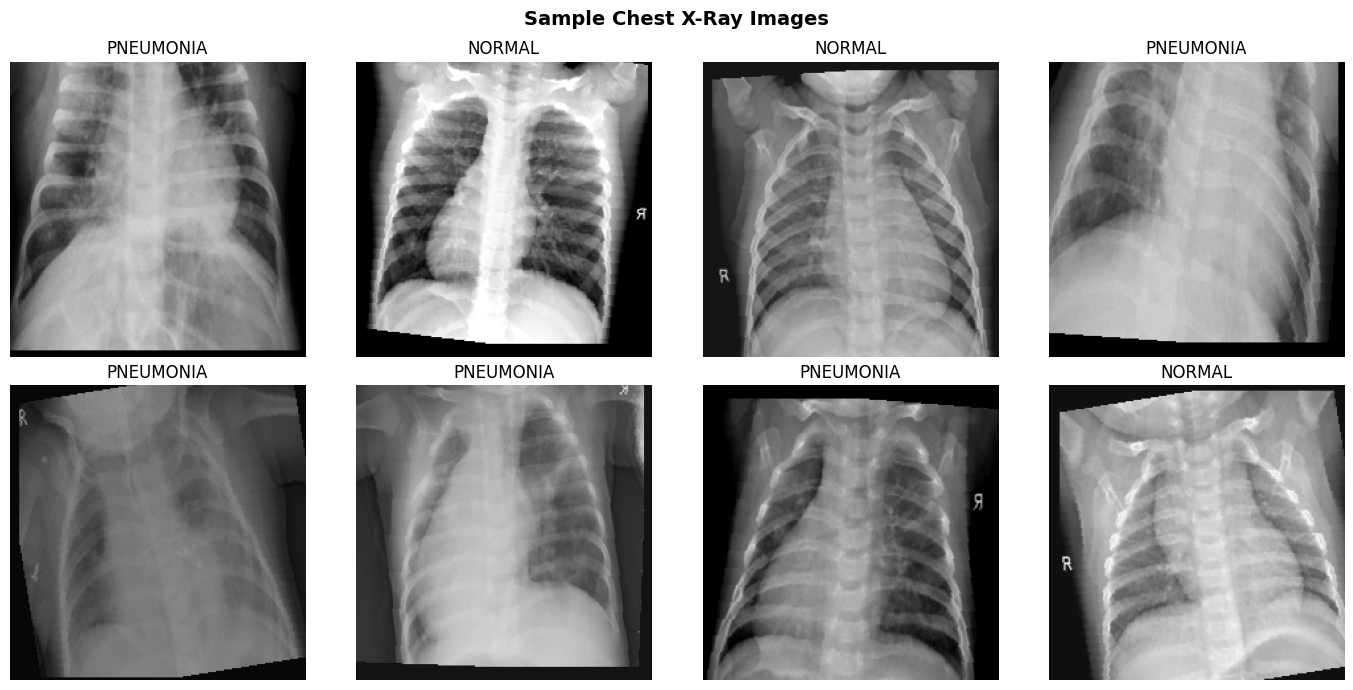

In [12]:
# Visualize sample images
def show_samples(dataset, class_names, n=8):
    fig, axes = plt.subplots(2, 4, figsize=(14, 7))

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    indices = np.random.choice(len(dataset), n, replace=False)

    for idx, ax in zip(indices, axes.flat):
        img, label = dataset[idx]
        img = img * std + mean
        img = img.permute(1, 2, 0).numpy().clip(0, 1)

        ax.imshow(img)
        ax.set_title(class_names[label], fontsize=12)
        ax.axis('off')

    plt.suptitle('Sample Chest X-Ray Images', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

show_samples(train_dataset_full, class_names)

## 5. Model Architecture

In [13]:
def build_model(num_classes, dropout=0.3):
    """
    EfficientNet-V2-S with custom classifier head.
    Same architecture as brain tumor model for consistency.
    """
    model = models.efficientnet_v2_s(weights='DEFAULT')

    # Freeze early layers
    for param in model.features[:5].parameters():
        param.requires_grad = False

    # Replace classifier head
    num_features = model.classifier[1].in_features
    model.classifier = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(p=dropout/2),
        nn.Linear(512, num_classes)
    )

    return model.to(device)

model = build_model(num_classes)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Model: EfficientNet-V2-S")
print(f"  Total parameters:     {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"  Output classes:       {num_classes}")

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 93.7MB/s]


Model: EfficientNet-V2-S
  Total parameters:     20,834,386
  Trainable parameters: 19,012,810
  Output classes:       2


## 6. Training Configuration

In [14]:
# Calculate class weights to handle imbalanced dataset
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.array([0, 1]),
    y=train_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

print(f"Class weights: {class_names[0]}={class_weights[0]:.3f}, {class_names[1]}={class_weights[1]:.3f}")

Class weights: NORMAL=1.988, PNEUMONIA=0.668


In [15]:
# Loss function with class weights and label smoothing
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.5,
    patience=2
)

# Mixed precision scaler
scaler = GradScaler('cuda')

print("Training configuration set")

Training configuration set


## 7. Training Loop

In [16]:
def train_epoch(model, loader, criterion, optimizer, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training', leave=False)
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()

        with autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100*correct/total:.1f}%'})

    return running_loss / total, 100 * correct / total


def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)

            with autocast('cuda'):
                outputs = model(images)
                loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

    return running_loss / total, 100 * correct / total

In [17]:
NUM_EPOCHS = 15
best_val_acc = 0.0
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

print("Starting Training...\n")
print(f"{'Epoch':^7} | {'Train Loss':^12} | {'Train Acc':^10} | {'Val Loss':^12} | {'Val Acc':^10} | {'LR':^10}")
print("-" * 75)

for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, scaler)
    val_loss, val_acc = validate(model, val_loader, criterion)

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        marker = ' *'
    else:
        marker = ''

    print(f"{epoch+1:^7} | {train_loss:^12.4f} | {train_acc:^10.2f}% | {val_loss:^12.4f} | {val_acc:^10.2f}% | {current_lr:^10.6f}{marker}")

print("\n" + "=" * 75)
print(f"Training complete. Best validation accuracy: {best_val_acc:.2f}%")

Starting Training...

 Epoch  |  Train Loss  | Train Acc  |   Val Loss   |  Val Acc   |     LR    
---------------------------------------------------------------------------


Training:   0%|          | 0/139 [00:00<?, ?it/s]

   1    |    0.3725    |   93.01   % |    0.3015    |   96.81   % |  0.001000  *


Training:   0%|          | 0/139 [00:00<?, ?it/s]

   2    |    0.3192    |   96.86   % |    0.3125    |   95.66   % |  0.001000 


Training:   0%|          | 0/139 [00:00<?, ?it/s]

   3    |    0.3158    |   97.20   % |    0.3343    |   94.64   % |  0.001000 


Training:   0%|          | 0/139 [00:00<?, ?it/s]

   4    |    0.3086    |   97.47   % |    0.2843    |   97.83   % |  0.001000  *


Training:   0%|          | 0/139 [00:00<?, ?it/s]

   5    |    0.2992    |   98.13   % |    0.2745    |   98.47   % |  0.001000  *


Training:   0%|          | 0/139 [00:00<?, ?it/s]

   6    |    0.3007    |   97.70   % |    0.2753    |   98.85   % |  0.001000  *


Training:   0%|          | 0/139 [00:00<?, ?it/s]

   7    |    0.2929    |   98.47   % |    0.2914    |   97.32   % |  0.001000 


Training:   0%|          | 0/139 [00:00<?, ?it/s]

   8    |    0.2934    |   98.40   % |    0.3114    |   96.04   % |  0.000500 


Training:   0%|          | 0/139 [00:00<?, ?it/s]

   9    |    0.2852    |   98.83   % |    0.2709    |   98.21   % |  0.000500 


Training:   0%|          | 0/139 [00:00<?, ?it/s]

  10    |    0.2775    |   99.28   % |    0.2791    |   97.83   % |  0.000500 


Training:   0%|          | 0/139 [00:00<?, ?it/s]

  11    |    0.2803    |   98.76   % |    0.2809    |   98.60   % |  0.000500 


Training:   0%|          | 0/139 [00:00<?, ?it/s]

  12    |    0.2785    |   99.03   % |    0.2749    |   98.72   % |  0.000250 


Training:   0%|          | 0/139 [00:00<?, ?it/s]

  13    |    0.2759    |   99.46   % |    0.2655    |   98.72   % |  0.000250 


Training:   0%|          | 0/139 [00:00<?, ?it/s]

  14    |    0.2724    |   99.57   % |    0.2752    |   97.96   % |  0.000250 


Training:   0%|          | 0/139 [00:00<?, ?it/s]

  15    |    0.2693    |   99.73   % |    0.2701    |   98.60   % |  0.000250 

Training complete. Best validation accuracy: 98.85%


## 8. Training Visualization

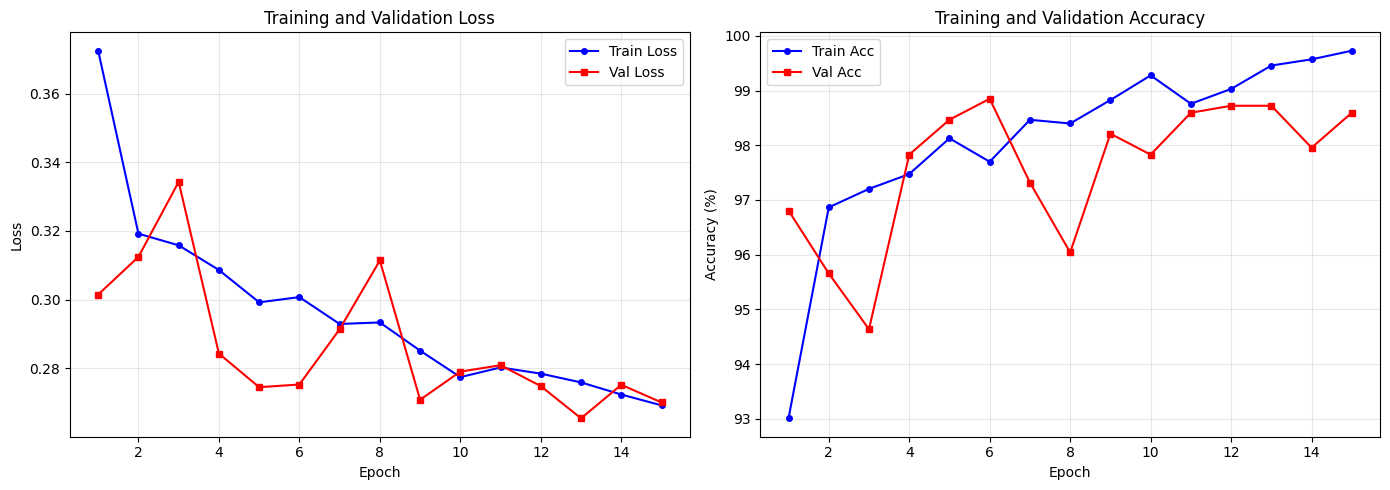

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs = range(1, len(history['train_loss']) + 1)

axes[0].plot(epochs, history['train_loss'], 'b-o', label='Train Loss', markersize=4)
axes[0].plot(epochs, history['val_loss'], 'r-s', label='Val Loss', markersize=4)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs, history['train_acc'], 'b-o', label='Train Acc', markersize=4)
axes[1].plot(epochs, history['val_acc'], 'r-s', label='Val Acc', markersize=4)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=150)
plt.show()

## 9. Evaluation on Test Set

In [19]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Evaluate on test set
test_loss, test_acc = validate(model, test_loader, criterion)
print(f"Test Set Results:")
print(f"  Loss:     {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.2f}%")

Test Set Results:
  Loss:     0.5186
  Accuracy: 88.46%


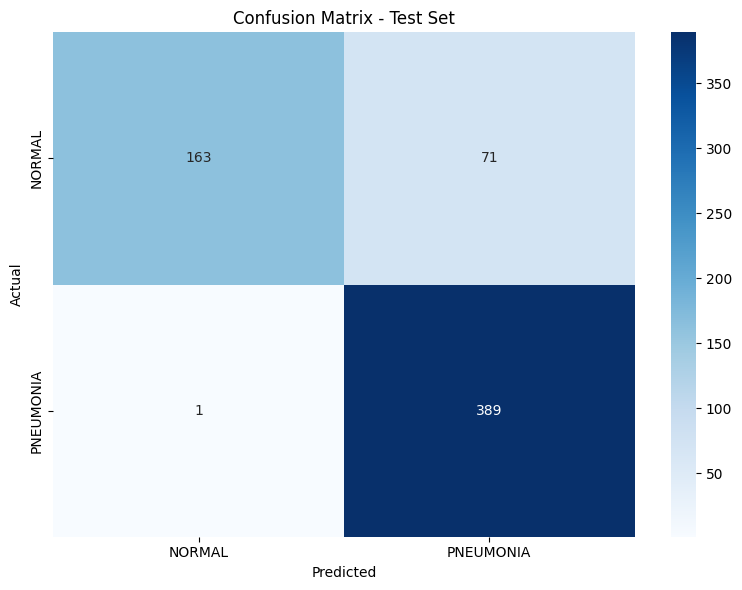


Classification Report:

              precision    recall  f1-score   support

      NORMAL       0.99      0.70      0.82       234
   PNEUMONIA       0.85      1.00      0.92       390

    accuracy                           0.88       624
   macro avg       0.92      0.85      0.87       624
weighted avg       0.90      0.88      0.88       624



In [20]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

all_preds = []
all_labels = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        with autocast('cuda'):
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())
        all_probs.extend(probs[:, 1].cpu().numpy())  # Probability of PNEUMONIA

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Test Set')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

print("\nClassification Report:\n")
print(classification_report(all_labels, all_preds, target_names=class_names))

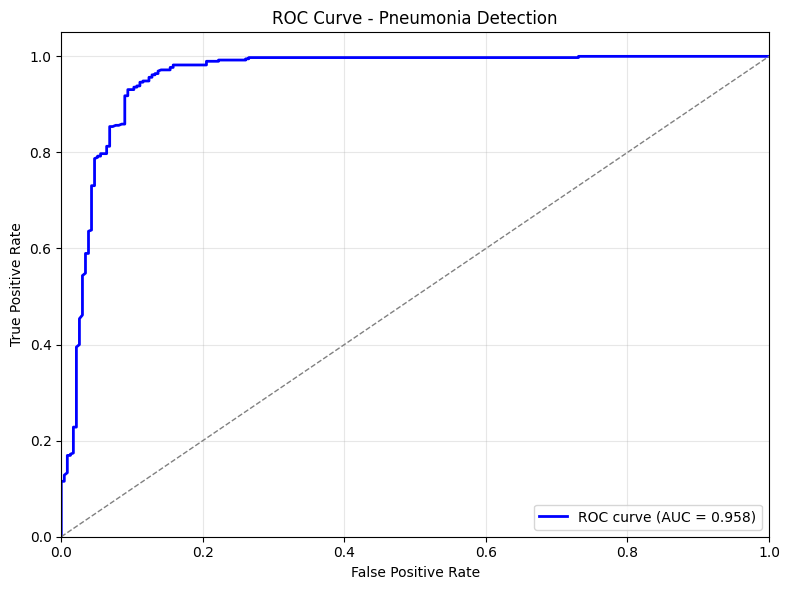

In [21]:
# ROC Curve (useful for binary classification)
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Pneumonia Detection')
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curve.png', dpi=150)
plt.show()

## 10. Save Model for Deployment

In [22]:
import os
os.makedirs('deployment', exist_ok=True)

# Save model weights
torch.save(model.state_dict(), 'deployment/pneumonia_model.pth')

# Save config
config = {
    'class_names': class_names,
    'num_classes': num_classes,
    'image_size': IMG_SIZE,
    'model_architecture': 'efficientnet_v2_s',
    'normalization': {
        'mean': [0.485, 0.456, 0.406],
        'std': [0.229, 0.224, 0.225]
    },
    'test_accuracy': test_acc,
    'training_epochs': NUM_EPOCHS
}

with open('deployment/pneumonia_config.json', 'w') as f:
    json.dump(config, f, indent=2)

print("Model saved for deployment")
print(f"\nFiles in deployment/:")
for f in os.listdir('deployment'):
    size = os.path.getsize(f'deployment/{f}') / 1e6
    print(f"  {f}: {size:.2f} MB")

Model saved for deployment

Files in deployment/:
  pneumonia_model.pth: 84.24 MB
  pneumonia_config.json: 0.00 MB


## 11. Grad-CAM Visualization

In [23]:
import torch.nn.functional as F
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        target_layer.register_forward_hook(self._forward_hook)
        target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output.detach()

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate(self, input_tensor, target_class=None):
        self.model.eval()

        output = self.model(input_tensor)

        if target_class is None:
            target_class = output.argmax(dim=1).item()

        self.model.zero_grad()
        one_hot = torch.zeros_like(output)
        one_hot[0, target_class] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().numpy()

        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)

        return cam, target_class

print("Grad-CAM class defined")

Grad-CAM class defined


Generating Grad-CAM visualizations...



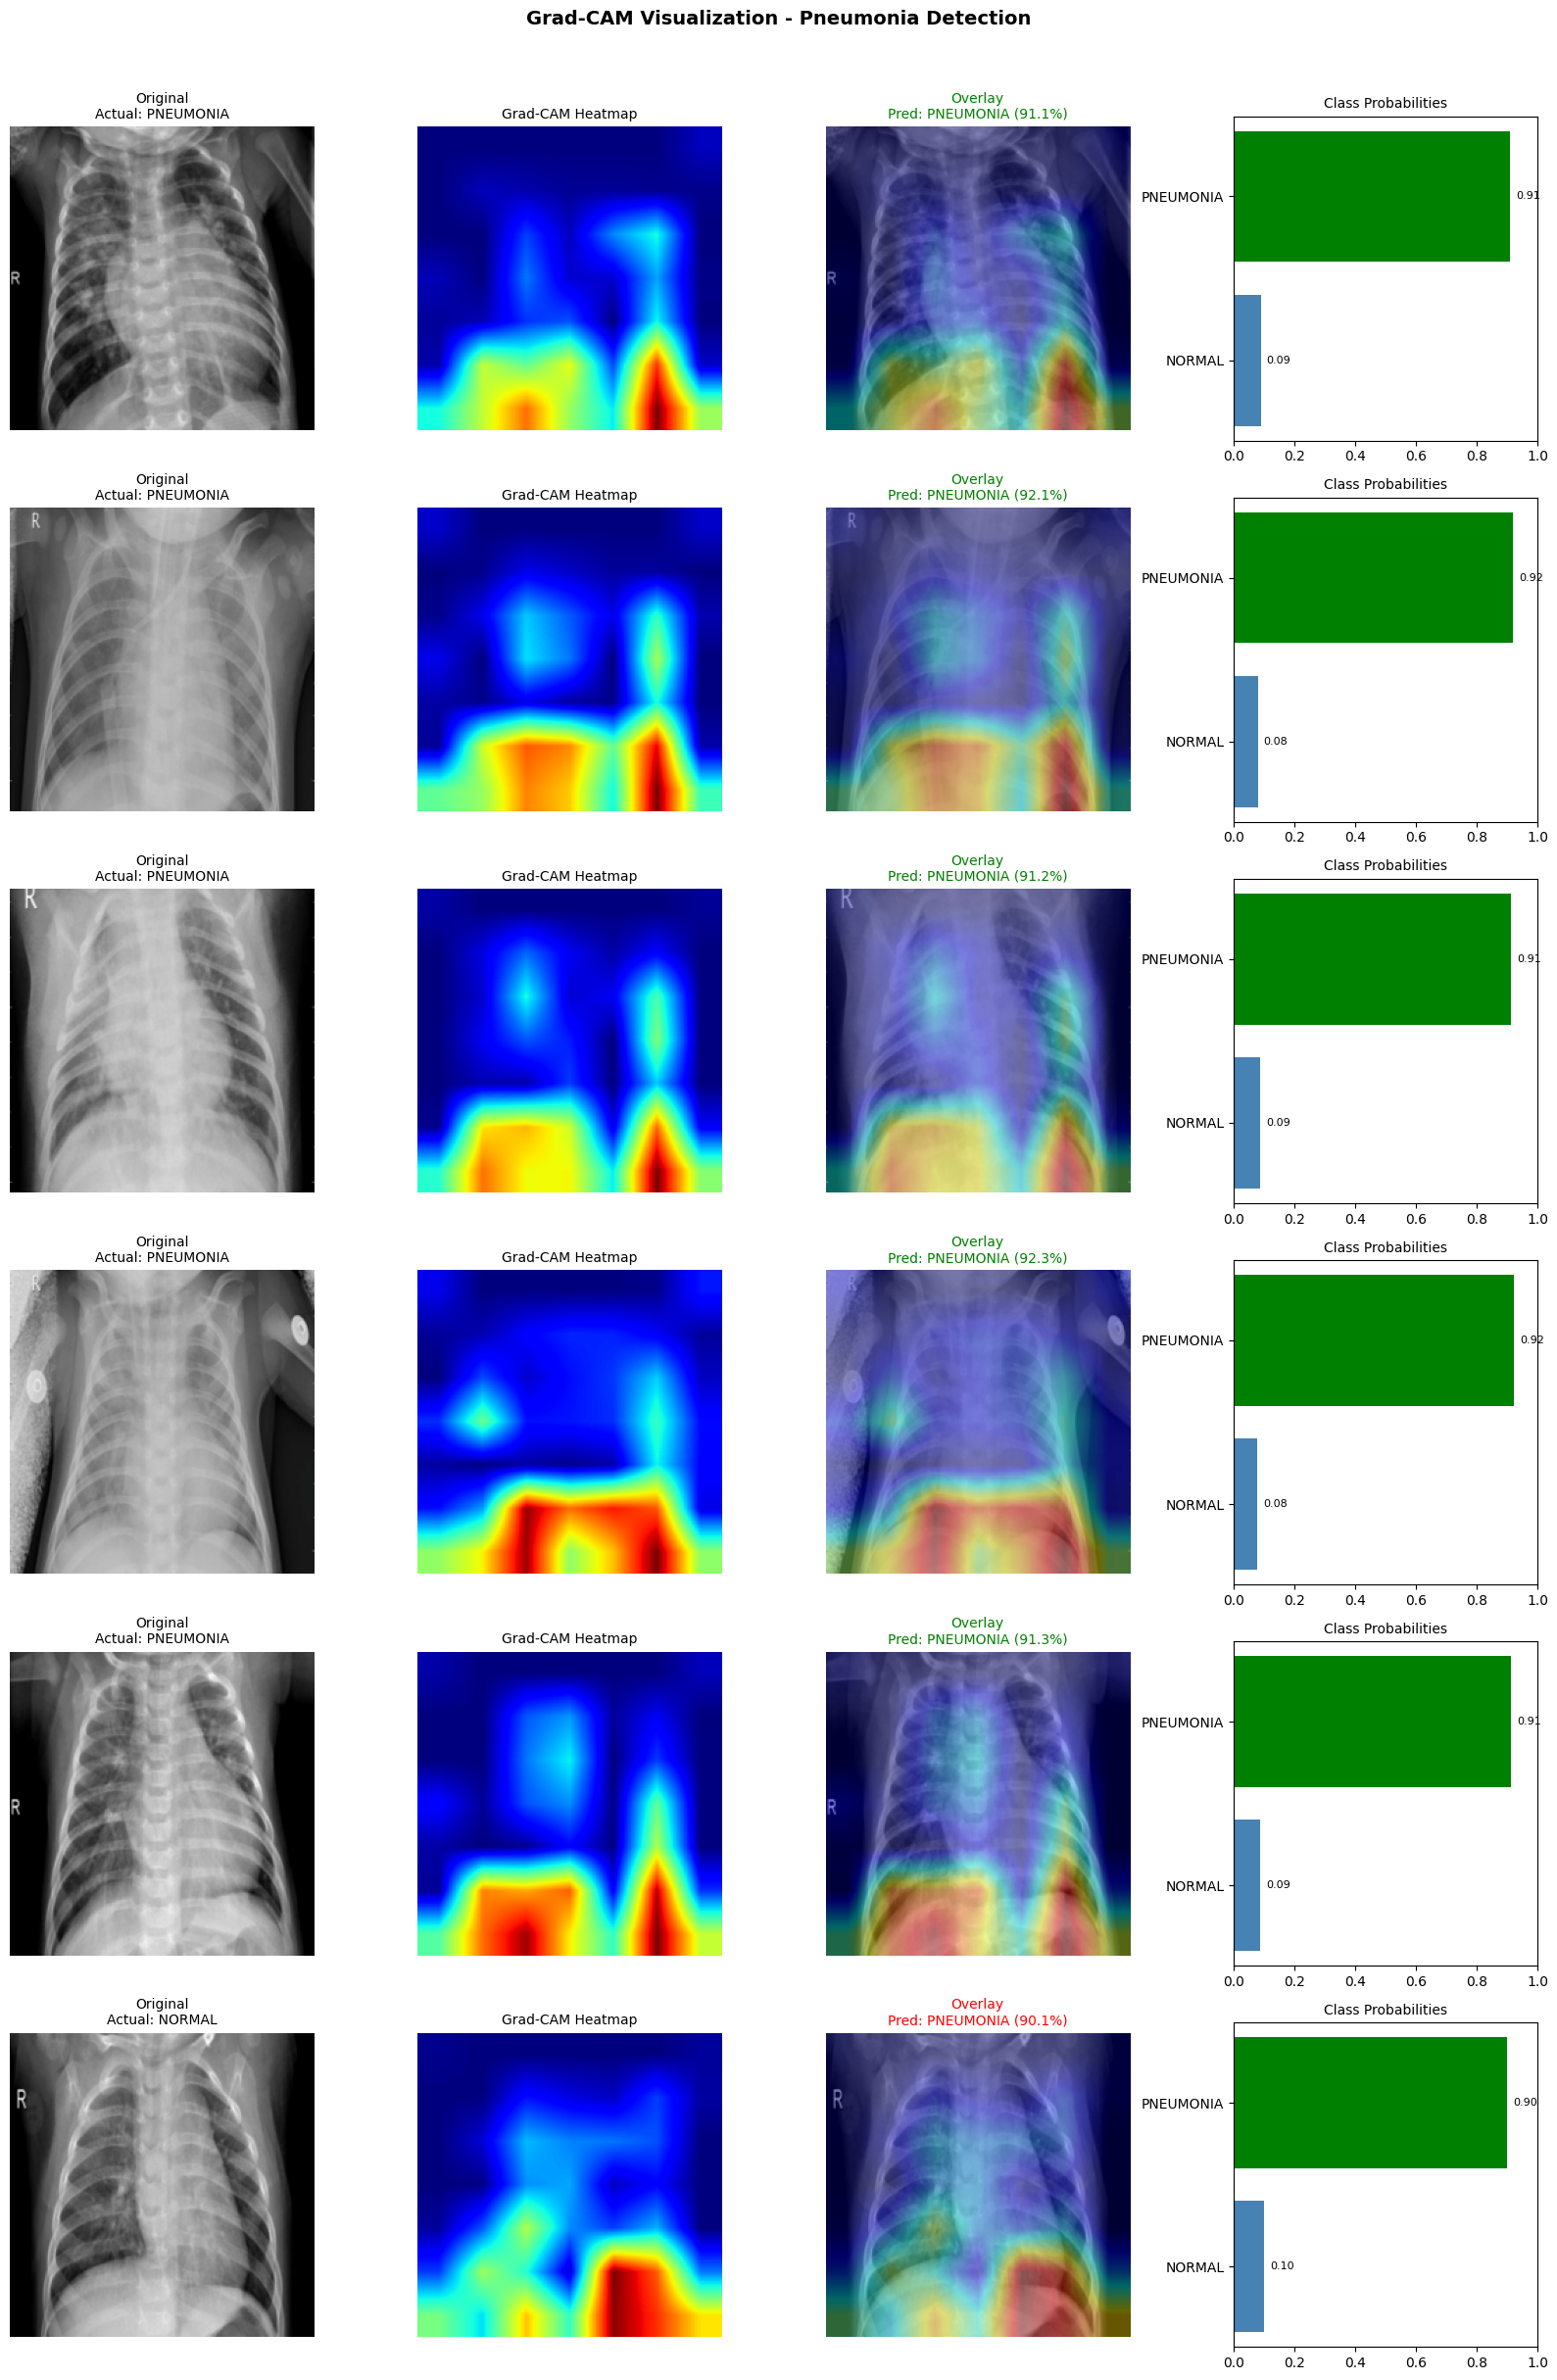

In [24]:
def visualize_gradcam(model, dataset, class_names, num_samples=8):
    target_layer = model.features[-1]
    gradcam = GradCAM(model, target_layer)

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    indices = np.random.choice(len(dataset), num_samples, replace=False)

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4 * num_samples))

    for i, idx in enumerate(indices):
        img_tensor, label = dataset[idx]
        input_tensor = img_tensor.unsqueeze(0).to(device)
        input_tensor.requires_grad_(True)

        with torch.no_grad():
            output = model(input_tensor)
            probs = torch.softmax(output, dim=1)
            conf, pred = probs.max(1)

        input_tensor.requires_grad_(True)
        heatmap, _ = gradcam.generate(input_tensor, pred.item())

        original = img_tensor.cpu().numpy().transpose(1, 2, 0)
        original = (original * std + mean).clip(0, 1)
        original_uint8 = (original * 255).astype(np.uint8)

        heatmap_resized = cv2.resize(heatmap, (224, 224))
        heatmap_colored = cv2.applyColorMap(
            (heatmap_resized * 255).astype(np.uint8),
            cv2.COLORMAP_JET
        )
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

        overlay = (0.6 * original_uint8 + 0.4 * heatmap_colored).astype(np.uint8)

        actual = class_names[label]
        predicted = class_names[pred.item()]
        confidence = conf.item() * 100
        is_correct = actual == predicted

        axes[i, 0].imshow(original)
        axes[i, 0].set_title(f'Original\nActual: {actual}', fontsize=10)
        axes[i, 0].axis('off')

        axes[i, 1].imshow(heatmap_resized, cmap='jet')
        axes[i, 1].set_title('Grad-CAM Heatmap', fontsize=10)
        axes[i, 1].axis('off')

        axes[i, 2].imshow(overlay)
        color = 'green' if is_correct else 'red'
        axes[i, 2].set_title(f'Overlay\nPred: {predicted} ({confidence:.1f}%)',
                            fontsize=10, color=color)
        axes[i, 2].axis('off')

        probs_np = probs[0].cpu().numpy()
        colors = ['green' if j == pred.item() else 'steelblue' for j in range(len(class_names))]
        axes[i, 3].barh(class_names, probs_np, color=colors)
        axes[i, 3].set_xlim(0, 1)
        axes[i, 3].set_title('Class Probabilities', fontsize=10)
        for j, v in enumerate(probs_np):
            axes[i, 3].text(v + 0.02, j, f'{v:.2f}', va='center', fontsize=8)

    plt.suptitle('Grad-CAM Visualization - Pneumonia Detection',
                 fontsize=14, fontweight='bold', y=1.01)
    plt.tight_layout()
    plt.savefig('gradcam_visualization.png', dpi=150, bbox_inches='tight')
    plt.show()

print("Generating Grad-CAM visualizations...\n")
visualize_gradcam(model, test_dataset, class_names, num_samples=6)

## 12. Download Deployment Package

In [25]:
from google.colab import files
import shutil

shutil.make_archive('pneumonia_deployment', 'zip', 'deployment')

print("Downloading deployment package...")
files.download('pneumonia_deployment.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [26]:
# Download visualizations
files.download('gradcam_visualization.png')
files.download('confusion_matrix.png')
files.download('roc_curve.png')
files.download('training_history.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>